# 勾配法と誤差逆伝播法
ニューラルネットワークにおいて，効率よく各重みの勾配を推定することで貢献度割り当て問題を解決する方法が**誤差逆伝播法** (backpropagation) である．本節では入力層，隠れ層，出力層からなる多層ニューラルネットワークを実装し，誤差逆伝播法による勾配推定を用いて学習を行う．

本書では誤差逆伝播法を用いない学習法を実施することも考慮し，数式と対応するような実装を行う．そのため，Deep Learningライブラリ (PyTorch, Flux.jl等) のようにLayerを定義し，それを繋げてモデルを定義するということや計算グラフの構築は行わない．

In [1]:
using Base: @kwdef
#using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, PyPlot, ProgressMeter
#using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter
#using BenchmarkTools; @btime
rc("axes.spines", top=false, right=false)

活性化関数 (activation function) の構造体を`ActivationFunction` と定義する．この構造体には`forward` と `backward`の2種類の関数フィールド (field; 構造体の要素のこと) を持たせておく．2種類の関数はそれぞれ順伝播時と逆伝播時に使用する．

In [2]:
struct ActivationFunction
    forward::Function   # function for forward propagation
    backward::Function  # function for back-propagation
end

また，次のコードにより，構造体のインスタンスを関数として使用できるようにしておく．これはcallable objectと呼ばれる．

In [3]:
(f::ActivationFunction)(x) = f.forward(x)

代表的な活性化関数を紹介する．なお，`backward` における `y` は `forward` での出力に対応する．これは活性化関数を作用させる前の変数 ($x$であり，膜電位に対応する) を保持しておかなくても良いようにするためである．

シグモイド関数 (sigmoid function) あるいはロジスティック関数 (logistic function) の場合，

$$
\begin{align}
&\textrm{forward: } y = \frac{1}{1+e^{-x}}\\
&\textrm{backward: } \frac{dy}{dx} =\frac{e^{-x}}{(1+e^{-x})^2}= y\cdot (1-y)\\
\end{align}
$$

tanh関数の場合，

$$
\begin{align}
&\textrm{forward: } y = \frac{e^x-e^{-x}}{e^x+e^{-x}}\\
&\textrm{backward: } \frac{dy}{dx} =\frac{(e^x+e^{-x})(e^x+e^{-x})-(e^x-e^{-x})(e^x-e^{-x})}{(e^x+e^{-x})^2}= 1-y^2\\
\end{align}
$$

ReLU関数 (rectified linear unit function, 正規化線形関数) あるいはランプ関数 (ramp function)の場合，

$$
\begin{align}
&\textrm{forward: } y = \max(x, 0)\\
&\textrm{backward: } \frac{dy}{dx} = \mathbf{1}_{x > 0}(x) = \mathbf{1}_{y > 0}(y)\\
\end{align}
$$

ただし，$\max(a, b)$は, $a, b$のうち，大きい値を返す関数である．また，$\mathbf{1}_{A}(x)$ は指示関数 (indicator function)であり，$x\in A$ ならば $\mathbf{1}_A(x)=1$ であり，それ以外の場合は $\mathbf{1}_A(x)=0$ となる関数である．ReLU関数は $x=0$ で折れ曲がるが，その他では線形であるため，区分線形関数 (piecewise linear function) の一種であると言える．

これらの活性化関数を構造体 `ActivationFunction`を用いて実装する．

In [4]:
Sigmoid = ActivationFunction(
    x -> 1.0 ./ (1.0 .+ exp.(-x)),
    y -> y .* (1 .- y)
)

Tanh = ActivationFunction(
    x -> tanh.(x),
    y -> 1 .- y .^ 2
)

Relu = ActivationFunction(
    x -> max.(0, x),
    y -> y .> 0
)

Identity = ActivationFunction(
    x -> x, # or use `identity` function
    y -> fill!(similar(y), 1)
);

Softplus = ActivationFunction(
    x -> log.(1 .+ exp.(x)),
    y -> (exp.(y) .- 1) ./ exp.(y)
    )

ActivationFunction(var"#17#19"(), var"#18#20"())

ニューラルネットワークのパラメータを保持する構造体を定義する．

In [5]:
abstract type NeuralNet end
(f::NeuralNet)(x) = forward!(f, x)

ニューラルネットワーク内の学習可能なパラメータ (learnable parameter) を保持する構造体を定義する．各パラメータはそれ自体の値 (value) と損失関数に対する勾配 (gradient) を持つ．

In [6]:
mutable struct Param
    v::Array
    grad::Array

    Param(value) = new(value, zero(value))
end

In [7]:
struct MLP <: NeuralNet
    L::Int # num. of layers
    W::Vector{Param}; b::Vector{Param}   # weights and bias
    B::Vector{Array} # backward weight
    z::Vector{Array}; δ::Vector{Array}   # state of forward/backward activity
    f::Vector{ActivationFunction} # activation functions of layers

    function MLP(n_units::Vector{Int}; f_hid::ActivationFunction=Sigmoid, f_out::ActivationFunction=Identity, init_type="He")
        L = length(n_units) - 1
        # initialization of parameters
        if init_type == "He"
            W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/n_units[l])) for l in 1:L] # He
            B = [2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/n_units[l]) for l in 1:L] # He
        else
            W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/(n_units[l]+n_units[l+1]))) for l in 1:L] # Xavier
            B = [2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/(n_units[l]+n_units[l+1])) for l in 1:L] # Xavier
        end
        b = [Param(zeros(1, n_units[l+1])) for l in 1:L]
        
        # initialization of forward / backward states
        z, δ = Vector{Array}(undef, L+1), Vector{Array}(undef, L)
        f = vcat([repeat([f_hid], L-1)..., f_out])
        new(L, W, b, B, z, δ, f)
    end
end

struct `MLP`を用意し，**重みの初期化(weight initialization)** を行う同名の関数`MLP`を用意する．重みの初期化に関しては，各層の出力および勾配の分散が一定となるような初期化をすることで学習が進行することが知られている．出力は活性化関数に依存するため，初期化についても活性化関数に応じて変更することが推奨され，sigmoid関数やtanh関数を用いる場合はXavierの初期化 \citep{Glorot2010-iu}，ReLU関数を用いる場合はHeの初期化 \citep{He2015-fs} が用いられる．入力ユニット数を $n_{\textrm{in}}$, 出力ユニット数を $n_{\textrm{out}}$ とすると，Xavierの初期化では重み $w$ の平均が0, 分散が $\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}$ となるように一様分布 $U\left(-\sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}, \sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)$ や正規分布 $\mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)$ 等から重みをサンプリングする．Heの初期化ではReLUを用いる場合，重み $w$ の平均が0, 分散が$\frac{2}{n_{\textrm{in}}}$ あるいは $\frac{2}{n_{\textrm{out}}}$ となるようにし，前者の分散を使用する場合は一様分布 $U\left(-\sqrt{\frac{6}{n_{\textrm{in}}}}, \sqrt{\frac{6}{n_{\textrm{in}}}}\right)$ や正規分布 $\mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}}}\right)$ 等から重みをサンプリングする．

### 順伝播 (forward propagation)
$f(\cdot)$を活性化関数とする．順伝播(feedforward propagation)は以下のようになる．$(\ell=1,\ldots,L)$

$$
\begin{align}
\text{入力層 : }&\mathbf{z}_1=\mathbf{x}\\
\text{隠れ層 : }&\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell\\
&\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)\\
\text{出力層 : }&\hat{\mathbf{y}}=\mathbf{z}_{L+1}
\end{align}
$$

実装における取り回しの都合上，以下では$f:=f_\ell\ (1, \ldots, L-1)$ とし，$g:=f_{L}$ は損失関数において記述されることとする．以下では`z[l]`は$\mathbf{z}_\ell \ (1, \ldots, L)$に対応するが，`z[L+1]`は$\mathbf{z}_{L+1}$ではなく$\mathbf{a}_{L}$に対応することに注意．

とするか？混乱をきたしかねないし，余計な計算が増える．softmaxをどうするか．

In [8]:
# forward computation of MLP
function forward!(mlp::MLP, x::Array)
    (;L, f, W, b, z) = mlp
    z[1] = x # input (n_batch x n_neurons)
    for l in 1:L
        z[l+1] = f[l](z[l] * W[l].v .+ b[l].v) # hidden layers
    end
    return z[L+1] # output
end

forward! (generic function with 1 method)

`W[l].v` は`l`番目の`Param`のインスタンスにおける`v`を取り出す操作である．

### 逆伝播 (backward propagation)
ニューラルネットワークの学習 (learning) あるいは訓練 (training) とは，目的関数 (objective function) あるいは損失関数 (loss function) と呼ばれる評価指標を可能な限り小さく (場合によっては大きく) するようなパラメータ集合 $\Theta = \{W_\ell, b_\ell\}_{\ell=1}^{L}$ を求める過程のことである．学習においてパラメータを最適化するアルゴリズムを**オプティマイザ** (optimizer) という．オプティマイザは多数提案されており，代表的なものを後ほど紹介する．まず，最も単純なオプティマイザである **勾配降下法** (gradient descent; GD) を紹介する．勾配降下法では全データを用いてパラメータ $\theta \in \Theta$ の更新量 $\Delta \theta$ を 

$$
\Delta \theta = -\eta \frac{\partial \mathcal{L}_{\textrm{GD}}}{\partial \theta} = -\frac{\eta}{N} \sum_{i=1}^N \frac{\partial \mathcal{L}^{(i)}}{\partial \theta}
$$

として計算する (パラメータは$\theta\leftarrow \theta + \Delta \theta$により更新される)．ただし，$\mathcal{L}_{\textrm{GD}}:=\frac{1}{N}\sum_{i=1}^N \mathcal{L}^{(i)}$ であり，$\mathcal{L}^{(i)}$は$i$ 番目のサンプルに対する目的関数であり，$N$ は全データのサンプル数を意味する．$\eta$ は学習率 (learning rate) である．オプティマイザは一般的に勾配 $\dfrac{\partial \mathcal{L}}{\partial \theta}$ の計算を必要とする．この計算を効率よく行う手法が**誤差逆伝播法** (backpropagation) である．誤差逆伝播法は連鎖律 (chain rule; 合成関数の微分の関係式) を用いて導くことができる．$\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell$ および $\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)$ であることを踏まえると，

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}\\
\delta_L&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}\\
\mathbf{\delta}_\ell&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\ell+1}} \frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_\ell}\\
&=\left(\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell+1}}\frac{\partial \mathbf{a}_{\ell+1}}{\partial \mathbf{z}_{\ell+1}}\right)\frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_{\ell}}\\
&={W_{\ell+1}}^\top \delta_{\ell+1} \odot f_\ell^{\prime}\left(\mathbf{a}_{\ell}\right)\\
\frac{\partial \mathcal{L}}{\partial W_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial W_\ell}=\delta_\ell \mathbf{z}_\ell^\top\\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial \mathbf{b}_\ell}=\delta_\ell
\end{align}
$$

が成り立つ．バッチ処理を考慮すると，行列を乗ずる順番が変わる．以下では$z=f(a), g(z)=f'(a)$として膜電位を使わず，発火率情報のみを使うようにしている．このようにできない関数もあるが，今回はこのように書き下せる活性化関数のみを扱う．

In [9]:
function backward!(mlp::MLP)
    (;L, W, b, B, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        if l < L
            δ[l] = δ[l+1] * B[l+1]' .* f[l].backward(z[l+1])
        end
        W[l].grad = z[l]' * δ[l] / n_batch
        b[l].grad = sum(δ[l], dims=1) / n_batch
    end
end

backward! (generic function with 1 method)

### 損失関数
回帰問題において，代表的に用いられるのが平均二乗誤差 (mean squared error) である．

$$
\begin{align}
\hat{\mathbf{y}} &= \mathbf{z}_{L+1}\\
\mathcal{L}&:=\frac{1}{2}\left\|\hat{\mathbf{y}}-\mathbf{y}\right\|^{2}\\
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}=\hat{\mathbf{y}}-\mathbf{y}\\
\delta_L&=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}=\left(\hat{\mathbf{y}}-\mathbf{y}\right) \odot f_L^{\prime}\left(\mathbf{a}_L\right)\\
\end{align}
$$

In [10]:
function squared_error!(nn::NeuralNet, y::Array)
    (;z, δ, f) = nn
    ŷ = z[end]
    n_batch = size(y)[1]
    error = ŷ - y
    loss = sum(error .^ 2) / n_batch
    δ[end] = error .* f[end].backward(ŷ)
    return loss
end

squared_error! (generic function with 1 method)

2クラス分類で用いられるのがバイナリ交差エントロピー (binary cross entropy) である．

In [11]:
clog(x) = max(log(x), -1e2) # clamped log

function binary_crossentropy!(nn::NeuralNet, y::Array)
    (;z, δ, f) = nn
    @assert f[end] == Sigmoid # f[end] must be sigmoid function
    ŷ = z[end]
    n_batch = size(y)[1]
    error = ŷ - y
    loss = -sum(y .* clog.(ŷ) + (1 .- y) .* clog.(1 .- ŷ)) / n_batch
    δ[end] = error
    return loss
end

binary_crossentropy! (generic function with 1 method)

多クラス分類課題で用いられるのが，softmaxおよびcross entropy lossである．
softmax関数は $\mathbf{y} = \text{softmax}(\mathbf{z})$ とすると，各成分を以下のように定義される．

$$
\begin{equation}
y_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
\end{equation}
$$

In [12]:
function softmax(x; dims=2)
    expx = exp.(x .- maximum(x, dims=dims))
    return expx ./ sum(expx, dims=dims)
end

Softmax = ActivationFunction(softmax, identity);

# t: labels (1 dims)
function cross_entropy_loss!(nn::NeuralNet, t::Vector)
    (;z, δ, f) = nn
    @assert f[end] == Softmax # f[end] must be softmax function
    ŷ = z[end]
    n_batch = length(t)
    idx = CartesianIndex.([(i, t[i]) for i in 1:n_batch])
    loss = -sum(clog.(ŷ[idx])) / n_batch
    grad = copy(ŷ)
    grad[idx] .-= 1
    δ[end] = grad / n_batch
    return loss
end

# t: probability (2 dims)
function cross_entropy_loss!(nn::NeuralNet, t::Array)
    (;z, δ, f) = nn
    @assert f[end] == Softmax # f[end] must be softmax function
    ŷ = z[end]
    n_batch = size(t)[1]
    loss = -sum(t .* clog.(ŷ)) / n_batch
    δ[end] = (ŷ - t) / n_batch
    return loss
end

cross_entropy_loss! (generic function with 2 methods)

Softmaxのbackwardは基本的に使用しないため，適当に`identity`関数などを入れておく．

### オプティマイザ
abstract typeとして`Optimizer`タイプを作成する．

In [13]:
abstract type Optimizer end

勾配降下法は$N$が大きい場合，あるいは1つのサンプルのデータサイズが大きい場合は非効率であるので，ニューラルネットワークの学習においては，データの部分集合であるミニバッチ (mini-bacth) を用いた **確率的勾配降下法** (stochastic gradient descent; SGD) が用いられる．
**確率的勾配降下法(stochastic gradient descent; SGD)** を実装する．

In [14]:
# SGD optimizer
@kwdef struct SGD{FT} <: Optimizer
    lr::FT=1e-2 # learning rate
end

function optimizer_update!(param::Param, optimizer::SGD; weight_decay=0)
    (;lr) = optimizer
    if weight_decay > 0
        param.grad += weight_decay * param.v
    end
    param.v -= lr * param.grad
end

optimizer_update! (generic function with 1 method)

次に**Adam** {cite:p}`Kingma2014-fm` を実装する．

In [15]:
# Adam optimizer
@kwdef mutable struct Adam <: Optimizer
    lr=1e-4; β1=0.9; β2=0.999; ϵ=1e-8
    ms=Dict(); vs=Dict();
end

# Adam optimizer
function optimizer_update!(param::Param, optimizer::Adam; weight_decay=0)
    (;lr, β1, β2, ϵ, ms, vs) = optimizer
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key], vs[key] = zero(param.v), zero(param.v)
    end
    if weight_decay > 0
        param.v -= lr * weight_decay * param.v
    end
    m, v = ms[key], vs[key]
    m += (1 - β1) * (param.grad - m)
    v += (1 - β2) * (param.grad .* param.grad - v)
    param.v -= lr * m ./ (sqrt.(v) .+ ϵ)
end

optimizer_update! (generic function with 2 methods)

重みのL2正則化 (Weight decay) を加える．正則化があることにより，実際のニューロンの活動を人工神経回路で再現できる研究も複数ある．バイアス項にはweight decayをしないため，optimizerの構造体の外からweight decayの値を与えることとする．

In [16]:
function optim_step!(nn::NeuralNet, optimizer::Optimizer; weight_decay=0)
    (;L, W, b) = nn
    # update weights
    for param in W
        optimizer_update!(param, optimizer, weight_decay=weight_decay)
    end

    # update bias (without weight decay)
    for param in b
        optimizer_update!(param, optimizer, weight_decay=0)
    end
end

optim_step! (generic function with 1 method)

In [17]:
function train_step!(nn::NeuralNet, x::Array, y::Array, loss_fun::Function; optimizer::Optimizer=SGD(), weight_decay=0)
    _ = nn(x)
    loss = loss_fun(nn, y)
    backward!(nn)
    optim_step!(nn, optimizer, weight_decay=weight_decay) # update params
    return loss
end

train_step! (generic function with 1 method)

## MNIST

`MNIST` の代わりに`FashionMNIST` を用いることもできる．MNISTは易しい課題であるため，MNISTを訓練できるからと言って複雑な課題でも機能する保証はない．とは言え，基本的なデータセットであるため，

In [18]:
using MLDatasets

In [19]:
trainset = MNIST(:train)
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

初回実行時はデータセットのダウンロードを行うか`[y/n]` (yes/no) の入力を求められるので`y`と入力する．

In [20]:
length(trainset)

60000

In [21]:
trainset[1]  # return first observation as a NamedTuple

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = 5)

In [22]:
X_train, y_train = trainset[:] # return all observations
y_train .+= 1; # 0-9 to 1-10

In [24]:
# training θeter
n_traindata = 20000 #or length(trainset)
n_batch = 100 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 200; # number of epoch

In [25]:
n_classes = 10
n_hid = 128
nn1 = MLP([28^2, n_hid, n_hid, n_classes], f_hid=Tanh, f_out=Softmax, init_type="Xavier")
loss_fun1 = cross_entropy_loss!

lr = 0.01  # learning rate
weight_decay = 0#.1 # weight decay (L2 norm) strength
optimizer1 = Adam(lr=lr); # SGD(lr=lr)#

In [26]:
cosine_distance(x,y) = dot(x,y)/(norm(x)*norm(y))

cosine_distance (generic function with 1 method)

In [27]:
error_arr = zeros(n_epoch); # memory array of each epoch error
cdist = zeros(nn1.L, n_epoch)
@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = Matrix(reshape(X_train[:, :, idx], (:, n_batch))'), y_train[idx]
        loss = train_step!(nn1, x, y, loss_fun1, optimizer=optimizer1, weight_decay=weight_decay)
        error_arr[e] += loss
    end 
    for i in 1:nn1.L
        cdist[i, e] = cosine_distance(nn1.W[i].v[:], nn1.B[i][:])
    end
    error_arr[e] /= n_traindata
    println("[$(e)/$(n_epoch)] train loss: $(error_arr[e])")
end

[1/200] train loss: 0.010457827473272233
[2/200] train loss: 0.008742505237011325

Training...   1%|█                                       |  ETA: 0:11:23

Training...   2%|█                                       |  ETA: 0:09:48

[3/200] train loss: 0.008109071953007693


Training...   2%|█                                       |  ETA: 0:08:21

[4/200] train loss: 0.008558400783373462


Training...   2%|██                                      |  ETA: 0:07:25

[5/200] train loss: 0.008648079161729195


Training...   3%|██                                      |  ETA: 0:06:46

[6/200] train loss: 0.008578756764453025


Training...   4%|██                                      |  ETA: 0:06:21

[7/200] train loss: 0.008416102076397312


Training...   4%|██                                      |  ETA: 0:05:58

[8/200] train loss: 0.008350740317554497


Training...   4%|██                                      |  ETA: 0:05:41

[9/200] train loss: 0.007932265889239494


Training...   5%|███                                     |  ETA: 0:05:28

[10/200] train loss: 0.008378404226309321


Training...   6%|███                                     |  ETA: 0:05:15

[11/200] train loss: 0.008208911453221168


Training...   6%|███                                     |  ETA: 0:05:05

[12/200] train loss: 0.008218339366420205


Training...   6%|███                                     |  ETA: 0:04:55

[13/200] train loss: 0.008137238480665707


[14/200] train loss: 0.0076928104422605585


Training...   8%|████                                    |  ETA: 0:04:41

[15/200] train loss: 0.00793618328302336


Training...   8%|████                                    |  ETA: 0:04:34

[16/200] train loss: 0.00792062999555149


Training...   8%|████                                    |  ETA: 0:04:28

[17/200] train loss: 0.0073124310707504275


Training...   9%|████                                    |  ETA: 0:04:22

[18/200] train loss: 0.007113694428453385


Training...  10%|████                                    |  ETA: 0:04:17

[19/200] train loss: 0.007305392061674938


Training...  10%|█████                                   |  ETA: 0:04:12

[20/200] train loss: 0.007230046305974784


Training...  10%|█████                                   |  ETA: 0:04:08

[21/200] train loss: 0.0075813062139139095


Training...  11%|█████                                   |  ETA: 0:04:04

[22/200] train loss: 0.007332585145604895


Training...  12%|█████                                   |  ETA: 0:04:00

[23/200] train loss: 0.007464291094700252


Training...  12%|█████                                   |  ETA: 0:03:56

[24/200] train loss: 0.007403348485303286


Training...  12%|██████                                  |  ETA: 0:03:52

[25/200] train loss: 0.007264325505609567


Training...  13%|██████                                  |  ETA: 0:03:49

[26/200] train loss: 0.006633757002785185


Training...  14%|██████                                  |  ETA: 0:03:46

[27/200] train loss: 0.006648903370644239


Training...  14%|██████                                  |  ETA: 0:03:43

[28/200] train loss: 0.006600151263157168


Training...  14%|██████                                  |  ETA: 0:03:40

[29/200] train loss: 0.006584727194838544


[30/200] train loss: 0.006470260485052043


Training...  16%|███████                                 |  ETA: 0:03:34

[31/200] train loss: 0.006784467954394265


Training...  16%|███████                                 |  ETA: 0:03:31

[32/200] train loss: 0.006783556826706156


Training...  16%|███████                                 |  ETA: 0:03:29

[33/200] train loss: 0.006403366429042399


Training...  17%|███████                                 |  ETA: 0:03:26

[34/200] train loss: 0.006502024692805397


Training...  18%|████████                                |  ETA: 0:03:24

[35/200] train loss: 0.006326595164335384


Training...  18%|████████                                |  ETA: 0:03:22

[36/200] train loss: 0.006482799320656965


Training...  18%|████████                                |  ETA: 0:03:19

[37/200] train loss: 0.006280067681864326


Training...  19%|████████                                |  ETA: 0:03:17

[38/200] train loss: 0.006051084529854065


[39/200] train loss: 0.006411517063462075


Training...  20%|█████████                               |  ETA: 0:03:12

[40/200] train loss: 0.006382432995519326


Training...  20%|█████████                               |  ETA: 0:03:10

[41/200] train loss: 0.00676043967008881


Training...  21%|█████████                               |  ETA: 0:03:08

[42/200] train loss: 0.006665685912693917


Training...  22%|█████████                               |  ETA: 0:03:07

[43/200] train loss: 0.006310112201962256


Training...  22%|█████████                               |  ETA: 0:03:05

[44/200] train loss: 0.006472556446725139


Training...  22%|██████████                              |  ETA: 0:03:03

[45/200] train loss: 0.006127901199493034


Training...  23%|██████████                              |  ETA: 0:03:01

[46/200] train loss: 0.00608240479105696


Training...  24%|██████████                              |  ETA: 0:02:59

[47/200] train loss: 0.006023198837366365


Training...  24%|██████████                              |  ETA: 0:02:57

[48/200] train loss: 0.006071788388427049


Training...  24%|██████████                              |  ETA: 0:02:56

[49/200] train loss: 0.005721172516577809


Training...  25%|███████████                             |  ETA: 0:02:54

[50/200] train loss: 0.00552391865843425


Training...  26%|███████████                             |  ETA: 0:02:52

[51/200] train loss: 0.005432383085828449


Training...  26%|███████████                             |  ETA: 0:02:51

[52/200] train loss: 0.0053749867101673746


Training...  26%|███████████                             |  ETA: 0:02:49

[53/200] train loss: 0.005282307975196295


Training...  27%|███████████                             |  ETA: 0:02:47

[54/200] train loss: 0.005416315658519581


Training...  28%|████████████                            |  ETA: 0:02:46

[55/200] train loss: 0.00549996372926396


Training...  28%|████████████                            |  ETA: 0:02:44

[56/200] train loss: 0.005372842197969626


Training...  28%|████████████                            |  ETA: 0:02:42

[57/200] train loss: 0.005333143365383548


Training...  29%|████████████                            |  ETA: 0:02:41

[58/200] train loss: 0.005378990983901201


Training...  30%|████████████                            |  ETA: 0:02:39

[59/200] train loss: 0.005587956938398026


Training...  30%|█████████████                           |  ETA: 0:02:38

[60/200] train loss: 0.005785849242021371


Training...  30%|█████████████                           |  ETA: 0:02:36

[61/200] train loss: 0.0055935602707162775


Training...  31%|█████████████                           |  ETA: 0:02:35

[62/200] train loss: 0.005719952241912286


Training...  32%|█████████████                           |  ETA: 0:02:33

[63/200] train loss: 0.0057302685479165855


Training...  32%|█████████████                           |  ETA: 0:02:31

[64/200] train loss: 0.005463632497245123


Training...  32%|██████████████                          |  ETA: 0:02:30

[65/200] train loss: 0.005379440783600397


Training...  33%|██████████████                          |  ETA: 0:02:28

[66/200] train loss: 0.005330983399435671


Training...  34%|██████████████                          |  ETA: 0:02:27

[67/200] train loss: 0.005308260286404744


Training...  34%|██████████████                          |  ETA: 0:02:26

[68/200] train loss: 0.005464807645529823


Training...  34%|██████████████                          |  ETA: 0:02:24

[69/200] train loss: 0.005263102501848237


Training...  35%|███████████████                         |  ETA: 0:02:23

[70/200] train loss: 0.005420920867910089


Training...  36%|███████████████                         |  ETA: 0:02:22

[71/200] train loss: 0.005561502088545102


[72/200] train loss: 0.00526445550252545


Training...  36%|███████████████                         |  ETA: 0:02:19

[73/200] train loss: 0.005356843098085808


Training...  37%|███████████████                         |  ETA: 0:02:18

[74/200] train loss: 0.00524649041844368


Training...  38%|████████████████                        |  ETA: 0:02:16

[75/200] train loss: 0.005107303735230923


Training...  38%|████████████████                        |  ETA: 0:02:15

[76/200] train loss: 0.005198205398689064


Training...  38%|████████████████                        |  ETA: 0:02:14

[77/200] train loss: 0.005079892311462473


Training...  39%|████████████████                        |  ETA: 0:02:12

[78/200] train loss: 0.004947324686869199


Training...  40%|████████████████                        |  ETA: 0:02:11

[79/200] train loss: 0.005194336434379044


Training...  40%|█████████████████                       |  ETA: 0:02:10

[80/200] train loss: 0.005156799365973488


Training...  40%|█████████████████                       |  ETA: 0:02:09

[81/200] train loss: 0.004957484468694557


Training...  41%|█████████████████                       |  ETA: 0:02:07

[82/200] train loss: 0.004937014178575343


Training...  42%|█████████████████                       |  ETA: 0:02:06

[83/200] train loss: 0.0050186096210607396


Training...  42%|█████████████████                       |  ETA: 0:02:05

[84/200] train loss: 0.005065221118596823


Training...  42%|██████████████████                      |  ETA: 0:02:04

[85/200] train loss: 0.0048263373338097324


Training...  43%|██████████████████                      |  ETA: 0:02:02

[86/200] train loss: 0.004871288175544023


Training...  44%|██████████████████                      |  ETA: 0:02:01

[87/200] train loss: 0.004885953635202404


Training...  44%|██████████████████                      |  ETA: 0:02:00

[88/200] train loss: 0.004908170696256163


Training...  44%|██████████████████                      |  ETA: 0:01:59

[89/200] train loss: 0.004849241012101475


Training...  45%|███████████████████                     |  ETA: 0:01:57

[90/200] train loss: 0.00477113665810981


Training...  46%|███████████████████                     |  ETA: 0:01:56

[91/200] train loss: 0.004723778910910189


Training...  46%|███████████████████                     |  ETA: 0:01:55

[92/200] train loss: 0.004713376984932772


Training...  46%|███████████████████                     |  ETA: 0:01:53

[93/200] train loss: 0.004915846751124514


Training...  47%|███████████████████                     |  ETA: 0:01:52

[94/200] train loss: 0.00489807752931363


Training...  48%|████████████████████                    |  ETA: 0:01:51

[95/200] train loss: 0.004916448073664664


Training...  48%|████████████████████                    |  ETA: 0:01:50

[96/200] train loss: 0.004949279321644034


Training...  48%|████████████████████                    |  ETA: 0:01:48

[97/200] train loss: 0.0050529412019288305


Training...  49%|████████████████████                    |  ETA: 0:01:47

[98/200] train loss: 0.004907239120721554


Training...  50%|████████████████████                    |  ETA: 0:01:46

[99/200] train loss: 0.004643870826761537


Training...  50%|█████████████████████                   |  ETA: 0:01:45

[100/200] train loss: 0.004814194960658797


[101/200] train loss: 0.004978236510130881


Training...  51%|█████████████████████                   |  ETA: 0:01:42

[102/200] train loss: 0.005045989673980478


Training...  52%|█████████████████████                   |  ETA: 0:01:41

[103/200] train loss: 0.004853854566013637


Training...  52%|█████████████████████                   |  ETA: 0:01:40

[104/200] train loss: 0.004647401458052765


Training...  52%|██████████████████████                  |  ETA: 0:01:39

[105/200] train loss: 0.004802511288151452


Training...  53%|██████████████████████                  |  ETA: 0:01:38

[106/200] train loss: 0.004649037654472832


Training...  54%|██████████████████████                  |  ETA: 0:01:36

[107/200] train loss: 0.004759439830456931


Training...  54%|██████████████████████                  |  ETA: 0:01:35

[108/200] train loss: 0.004616143570025778


Training...  54%|██████████████████████                  |  ETA: 0:01:34

[109/200] train loss: 0.004756584138270501


Training...  55%|███████████████████████                 |  ETA: 0:01:33

[110/200] train loss: 0.004457028806487323


Training...  56%|███████████████████████                 |  ETA: 0:01:32

[111/200] train loss: 0.004323023938299863


Training...  56%|███████████████████████                 |  ETA: 0:01:31

[112/200] train loss: 0.004261316920016093


Training...  56%|███████████████████████                 |  ETA: 0:01:29

[113/200] train loss: 0.004309389445452315


Training...  57%|███████████████████████                 |  ETA: 0:01:28

[114/200] train loss: 0.004476416934744342


Training...  58%|████████████████████████                |  ETA: 0:01:27

[115/200] train loss: 0.004539615734083994


Training...  58%|████████████████████████                |  ETA: 0:01:26

[116/200] train loss: 0.004580835159861274


Training...  58%|████████████████████████                |  ETA: 0:01:25

[117/200] train loss: 0.0045932311240879965


Training...  59%|████████████████████████                |  ETA: 0:01:24

[118/200] train loss: 0.004525085346747396


Training...  60%|████████████████████████                |  ETA: 0:01:23

[119/200] train loss: 0.00451801039980276


Training...  60%|█████████████████████████               |  ETA: 0:01:22

[120/200] train loss: 0.004647739278828432


Training...  60%|█████████████████████████               |  ETA: 0:01:21

[121/200] train loss: 0.004562417625312849


Training...  61%|█████████████████████████               |  ETA: 0:01:19

[122/200] train loss: 0.00443139412395561


Training...  62%|█████████████████████████               |  ETA: 0:01:18

[123/200] train loss: 0.004566759501292038


Training...  62%|█████████████████████████               |  ETA: 0:01:17

[124/200] train loss: 0.004539460389934805


Training...  62%|██████████████████████████              |  ETA: 0:01:16

[125/200] train loss: 0.004592993918613842


Training...  63%|██████████████████████████              |  ETA: 0:01:15

[126/200] train loss: 0.004624019330485859


Training...  64%|██████████████████████████              |  ETA: 0:01:14

[127/200] train loss: 0.0049523096325201745


Training...  64%|██████████████████████████              |  ETA: 0:01:13

[128/200] train loss: 0.004624173763905346


Training...  64%|██████████████████████████              |  ETA: 0:01:12

[129/200] train loss: 0.00444615813412675


Training...  65%|███████████████████████████             |  ETA: 0:01:11

[130/200] train loss: 0.004427995033079897


Training...  66%|███████████████████████████             |  ETA: 0:01:10

[131/200] train loss: 0.004134262770607743


Training...  66%|███████████████████████████             |  ETA: 0:01:09

[132/200] train loss: 0.004069961708450373


Training...  66%|███████████████████████████             |  ETA: 0:01:07

[133/200] train loss: 0.004256137515637318


Training...  67%|███████████████████████████             |  ETA: 0:01:06

[134/200] train loss: 0.004356435672321982


Training...  68%|████████████████████████████            |  ETA: 0:01:05

[135/200] train loss: 0.004171826343281367


Training...  68%|████████████████████████████            |  ETA: 0:01:04

[136/200] train loss: 0.0042100160576887015


Training...  68%|████████████████████████████            |  ETA: 0:01:03

[137/200] train loss: 0.004076560740431022


Training...  69%|████████████████████████████            |  ETA: 0:01:02

[138/200] train loss: 0.004046705154282389


Training...  70%|████████████████████████████            |  ETA: 0:01:01

[139/200] train loss: 0.004167146461346125


Training...  70%|█████████████████████████████           |  ETA: 0:01:00

[140/200] train loss: 0.004128920096973815


Training...  70%|█████████████████████████████           |  ETA: 0:00:59

[141/200] train loss: 0.0042480804764583316


Training...  71%|█████████████████████████████           |  ETA: 0:00:58

[142/200] train loss: 0.0041471474565091485


[143/200] train loss: 0.004194162445560016


Training...  72%|█████████████████████████████           |  ETA: 0:00:56

[144/200] train loss: 0.004142614110533084


Training...  72%|██████████████████████████████          |  ETA: 0:00:55

[145/200] train loss: 0.003993160878090091


Training...  73%|██████████████████████████████          |  ETA: 0:00:54

[146/200] train loss: 0.004057377369099914


Training...  74%|██████████████████████████████          |  ETA: 0:00:53

[147/200] train loss: 0.004323782766782468


Training...  74%|██████████████████████████████          |  ETA: 0:00:52

[148/200] train loss: 0.004183756554736115


Training...  74%|██████████████████████████████          |  ETA: 0:00:51

[149/200] train loss: 0.004111260723409097


Training...  75%|███████████████████████████████         |  ETA: 0:00:50

[150/200] train loss: 0.004329590190846025


Training...  76%|███████████████████████████████         |  ETA: 0:00:49

[151/200] train loss: 0.004002601373628641


Training...  76%|███████████████████████████████         |  ETA: 0:00:48

[152/200] train loss: 0.004161561698734267


Training...  76%|███████████████████████████████         |  ETA: 0:00:47

[153/200] train loss: 0.004154198396639974


Training...  77%|███████████████████████████████         |  ETA: 0:00:46

[154/200] train loss: 0.0043213108681147755


Training...  78%|████████████████████████████████        |  ETA: 0:00:45

[155/200] train loss: 0.004070585970759574


Training...  78%|████████████████████████████████        |  ETA: 0:00:44

[156/200] train loss: 0.00384093340647567


Training...  78%|████████████████████████████████        |  ETA: 0:00:43

[157/200] train loss: 0.004119237233351311


Training...  79%|████████████████████████████████        |  ETA: 0:00:42

[158/200] train loss: 0.004167637369740107


Training...  80%|████████████████████████████████        |  ETA: 0:00:41

[159/200] train loss: 0.0039036768926142278


Training...  80%|█████████████████████████████████       |  ETA: 0:00:40

[160/200] train loss: 0.0038567100400894966


Training...  80%|█████████████████████████████████       |  ETA: 0:00:39

[161/200] train loss: 0.00405977601869294


Training...  81%|█████████████████████████████████       |  ETA: 0:00:38

[162/200] train loss: 0.003971672365547176


Training...  82%|█████████████████████████████████       |  ETA: 0:00:37

[163/200] train loss: 0.004039140893544816


Training...  82%|█████████████████████████████████       |  ETA: 0:00:36

[164/200] train loss: 0.004055565575527038


Training...  82%|██████████████████████████████████      |  ETA: 0:00:35

[165/200] train loss: 0.004161790441465323


Training...  83%|██████████████████████████████████      |  ETA: 0:00:34

[166/200] train loss: 0.00415419499584671


Training...  84%|██████████████████████████████████      |  ETA: 0:00:33

[167/200] train loss: 0.004032824278706069


Training...  84%|██████████████████████████████████      |  ETA: 0:00:32

[168/200] train loss: 0.0041705729782019595


Training...  84%|██████████████████████████████████      |  ETA: 0:00:31

[169/200] train loss: 0.00444739084921649


Training...  85%|███████████████████████████████████     |  ETA: 0:00:30

[170/200] train loss: 0.004165045677052316


Training...  86%|███████████████████████████████████     |  ETA: 0:00:29

[171/200] train loss: 0.004074626414434917


Training...  86%|███████████████████████████████████     |  ETA: 0:00:28

[172/200] train loss: 0.0040897458533682


Training...  86%|███████████████████████████████████     |  ETA: 0:00:27

[173/200] train loss: 0.004032909347237906


Training...  87%|███████████████████████████████████     |  ETA: 0:00:26

[174/200] train loss: 0.0041514724016960035


Training...  88%|████████████████████████████████████    |  ETA: 0:00:25

[175/200] train loss: 0.004163037925034393


Training...  88%|████████████████████████████████████    |  ETA: 0:00:24

[176/200] train loss: 0.004162595991063966


Training...  88%|████████████████████████████████████    |  ETA: 0:00:23

[177/200] train loss: 0.0040157338388436695


Training...  89%|████████████████████████████████████    |  ETA: 0:00:22

[178/200] train loss: 0.00405080653032766


Training...  90%|████████████████████████████████████    |  ETA: 0:00:21

[179/200] train loss: 0.004284009605776294


Training...  90%|█████████████████████████████████████   |  ETA: 0:00:20

[180/200] train loss: 0.004319289836083031


Training...  90%|█████████████████████████████████████   |  ETA: 0:00:19

[181/200] train loss: 0.004105755257873898


Training...  91%|█████████████████████████████████████   |  ETA: 0:00:18

[182/200] train loss: 0.004196627838541481


Training...  92%|█████████████████████████████████████   |  ETA: 0:00:17

[183/200] train loss: 0.004153990924144579


Training...  92%|█████████████████████████████████████   |  ETA: 0:00:16

[184/200] train loss: 0.004025035779801838


[185/200] train loss: 0.004160134570371055


Training...  93%|██████████████████████████████████████  |  ETA: 0:00:14

[186/200] train loss: 0.004022824307583916


Training...  94%|██████████████████████████████████████  |  ETA: 0:00:13

[187/200] train loss: 0.00398423827859244


Training...  94%|██████████████████████████████████████  |  ETA: 0:00:12

[188/200] train loss: 0.004192056400072001


Training...  94%|██████████████████████████████████████  |  ETA: 0:00:11

[189/200] train loss: 0.004272794699502821


Training...  95%|███████████████████████████████████████ |  ETA: 0:00:10

[190/200] train loss: 0.004182974342910894


Training...  96%|███████████████████████████████████████ |  ETA: 0:00:09

[191/200] train loss: 0.004407950559425426


Training...  96%|███████████████████████████████████████ |  ETA: 0:00:08

[192/200] train loss: 0.0039749831568259356


Training...  96%|███████████████████████████████████████ |  ETA: 0:00:07

[193/200] train loss: 0.003955130353273988


Training...  97%|███████████████████████████████████████ |  ETA: 0:00:06

[194/200] train loss: 0.0037447182747615344


Training...  98%|████████████████████████████████████████|  ETA: 0:00:05

[195/200] train loss: 0.0036487526366785795


Training...  98%|████████████████████████████████████████|  ETA: 0:00:04

[196/200] train loss: 0.003682964235810959


Training...  98%|████████████████████████████████████████|  ETA: 0:00:03

[197/200] train loss: 0.003793070844490135


Training...  99%|████████████████████████████████████████|  ETA: 0:00:02

[198/200] train loss: 0.004033021824278955


Training...  99%|████████████████████████████████████████|  ETA: 0:00:01

[199/200] train loss: 0.0039138669629677865
[200/200] train loss: 0.0038617383699362


Training... 100%|████████████████████████████████████████| Time: 0:03:14


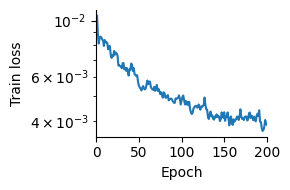

In [28]:
figure(figsize=(3,2))
semilogy(1:n_epoch, error_arr)
ylabel("Train loss"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

In [29]:
X_test, y_test = testset[:];

In [30]:
n_test = length(testset)

10000

In [31]:
size(nn1.W[1].v)

(784, 128)

Dying Relu現象

In [32]:
weight = reshape(nn1.W[1].v', (n_hid, 28, 28));

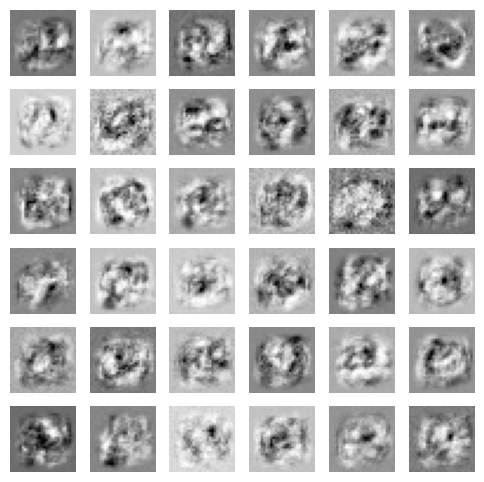

In [33]:
fig, axes = subplots(6, 6, figsize=(6,6))
axf = axes[:]
for i in 1:36#n_hid
    axf[i].imshow(weight[i, :, :], cmap="Greys")
    axf[i].axis("off")
end

In [34]:
"""
for i in 1:5
    subplots()
    imshow(x')
end
"""

"for i in 1:5\n    subplots()\n    imshow(x')\nend\n"

In [35]:
x_test = Matrix(reshape(X_test, (28^2, :))');

In [36]:
y_pred = nn1(x_test);

In [37]:
t_pred = getindex.(argmax(y_pred, dims=2), 2) .- 1;

In [38]:
accuracy = sum(t_pred .== y_test) / n_test * 100

91.83

In [39]:
confusion_matrix = zeros(n_classes, n_classes)
for i in 1:n_test
    confusion_matrix[y_test[i]+1, t_pred[i]+1] += 1
end

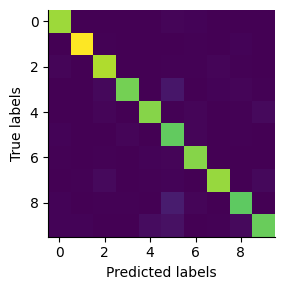

In [40]:
figure(figsize=(3,3))
imshow(confusion_matrix)
xlabel("Predicted labels")
ylabel("True labels")
tight_layout()